

---

# Chilling Effect Explained - Analyzing Other Causes of Wikipedia Views Changes in the Context of World Historical Events

---

## Abstract

In the original Chilling Effects paper, the authors decided to remove Hamas from the set of analized topics, due to the ongoing conflict in the Middle East which was causing the values of average views per month to skyrocket. This action highlights two weaknesses of the author’s analysis. First, the average score might be dominated by the trends of a single, highly popular wikipedia page from the selected set. Second, there might be more highly significant historical events which affected the analysis by generating increased traffic to the pages related to the event.
In this work, we will make an effort to improve the analysis and address the aforementioned problems using the original data and the Google Trends from the related timespan. We will then reproduce the analysis on the new data to show whether the phenomenon described in the paper can be still observable with statistically significant confidence.

---

## Research questions

* How big is the importance of each separate article trend on the original paper results?
* How important was the influence of the external events on the weekly wikipedia views?
* Is the original paper's result still relevant if we reduce the impact of "breaking news" and topic popularity disproportion in the original data, as such can the results be reproduced using a more general data set, such as Google Trends?

---

## Datasets

* Dataset of Wikipedia view count provided by the TA with re-downloaded last two months
* Dataset of Google Trends counts. Google Trends dataset is interesting because it uses a (random) sample of the queries in the google search bar, which is more general than just analysing the wikipedia views. Google trends allows us to explore the magnitude of trends in searches, in a scale from 0 to 100. It illustrates the interest as a proportion of all searches on all topics on Google at that time and location (https://medium.com/google-news-lab/what-is-google-trends-data-and-what-does-it-mean-b48f07342ee8). It is easy to download the data we want with the button ‘Download’. We get a csv file with two columns : the week and the interest on the 0-100 scale from the wanted keyword. We would do that for all of our subjects. We can identify sharp spikes in interest which correspond to the news, and identify outliers that were not accounted for in the study. The use of Google Trends to find them is relevant because generally, for events and news, people are looking things up in Google, and only after click on the wikipedia article directly from the search engine. We would like to remove the outliers because what interests us in our study is to see if there is a long-lasting effect from the event of June 2013, not from other external events. 

---

## Steps

* Data acquisition
  * Terrorism Data
  * Domestic Data
  * Google Trends Data
  * Statistics On The Data
* Most Important Topics
  * Top Five
  * World Cloud
  * Plotly World Cloud
* Analyse Of Google Trends For Keywords
  * Identify What Makes An Outlier
  * Visualize Outliers
  * Linking Outliers With Related Events
  * Example of Chemical Weapon
  * Example of Car Bomb
* Wikipedia Without Outliers
  * From The Paper
  * Removing Outliers in Wikipedia
  * Segmented Regression Analysis
  * Plotly Segmented Regression
* Analysis of Results And Conclusion

---

## Data acquisition

In [1]:
!pip install pytrends wordcloud plotly

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import numpy as np
from dateutil.relativedelta import *
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from wordcloud import WordCloud
import plotly.graph_objs as go
import statsmodels.formula.api as smf

### Terrorism data

To begin with, we collect the Wikipedia data for the articles. We start by re-uploading the dataset from the TAs, in order to retrieve the list of articles in the dataset of the paper.  

In [3]:
# Read the provided wikipedia articles views dataset from S3
df_terrorism = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/terrorism_data_30.csv")

terrorism_article_names = df_terrorism.drop_duplicates(subset = ["article"])['article']

# Drop the irrelevant columns: project, id, article name
df_terrorism = df_terrorism.drop(df_terrorism.columns[0:2], axis=1)
df_terrorism.date = pd.to_datetime(df_terrorism.date)
df_terrorism = df_terrorism.set_index("date")
df_terrorism.head()

,article,views
date,,
2012-01-01,abu_sayyaf,254
2012-01-01,al-qaeda,2688
2012-01-01,al-qaeda_in_the_arabian_peninsula,104
2012-01-01,al-qaeda_in_the_islamic_maghreb,8
2012-01-01,al-shabaab,951


We now group each same article together, summing by week frequency, and replace the missing data from the last months. We gathered the data from Wikidumps. 


In [4]:
# Grouping by article and week
terrorism_grouped = df_terrorism.groupby(["article", pd.Grouper(freq='W')])[["views"]].sum().reset_index()

# Data from July 2014
replace_1_terrorism = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/2014-07.csv")
replace_1_terrorism.date = pd.to_datetime(replace_1_terrorism.date)
replace_1_terrorism = replace_1_terrorism[replace_1_terrorism.article.isin(terrorism_article_names)]
replace_1_terrorism = replace_1_terrorism.set_index("date").groupby(["article", pd.Grouper(freq='W')])[["views"]].sum().reset_index()

# Data from August 2014
replace_2_terrorism = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/2014-08.csv")
replace_2_terrorism.date = pd.to_datetime(replace_2_terrorism.date)
replace_2_terrorism = replace_2_terrorism[replace_2_terrorism.article.isin(terrorism_article_names)]
replace_2_terrorism = replace_2_terrorism.set_index("date").groupby(["article", pd.Grouper(freq='W')])[["views"]].sum().reset_index()

# Replacing the two months into the inital dataframe
replace_terrorism = pd.concat([replace_1_terrorism, replace_2_terrorism])
replace_terrorism = replace_terrorism.groupby(by=["article", "date"]).sum().reset_index()

terrorism_grouped.loc[terrorism_grouped.date.isin(replace_terrorism.date), ["views"]] = replace_terrorism.views.values
terrorism_grouped = terrorism_grouped.set_index("date")

terrorism_grouped.head()

,article,views
date,,
2012-01-01,abu_sayyaf,254
2012-01-08,abu_sayyaf,3970
2012-01-15,abu_sayyaf,2915
2012-01-22,abu_sayyaf,2442
2012-01-29,abu_sayyaf,2593


Terrorism data is ready for further work! Let's have a quick look at it.

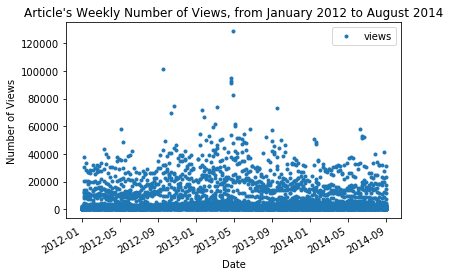

In [5]:
terrorism_grouped.plot(title="Article's Weekly Number of Views, from January 2012 to August 2014", xlabel = 'Date', ylabel = 'Number of Views', style='.')

We see that the number of weekly views for each article is between 0 and 7500, with some outliers going up to 17500. We can keep in mind that this outlier might have a significant role in determining wether or not there is a chilling effect.

### Domestic data

We also load domestic data, that is the control group of the study, for the same reasons as in the paper. The views of domestic security topics should not be affected by the chilling effect.

In [6]:
# Read the provided dataset from S3
df_domestic = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/domestic_data.csv")

domestic_article_names = df_domestic.drop_duplicates(subset = ["article"])['article']
# Drop the irrelevant columns: project, id, article name
df_domestic = df_domestic.drop(df_domestic.columns[0:2], axis=1)
df_domestic.date = pd.to_datetime(df_domestic.date)
df_domestic = df_domestic.set_index("date")
df_domestic.head()

,article,views
date,,
2012-01-01,air_marshal,383
2012-01-01,alcohol_and_tobacco_tax_and_trade_bureau,64
2012-01-01,border_patrol,38
2012-01-01,bureau_of_land_management,135
2012-01-01,central_intelligence_agency,2964


We do the same treatment as with the study group. We group each same article together, summing by week frequency, and replace the missing data from the last months, with data gathered from Wikidumps. 

In [7]:
# Grouping by article and week
domestic_grouped = df_domestic.groupby(["article", pd.Grouper(freq='W')])[["views"]].sum().reset_index()

# Data from July 2014
replace_1_domestic = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/2014-07-domestic.csv")
replace_1_domestic.date = pd.to_datetime(replace_1_domestic.date)
replace_1_domestic = replace_1_domestic.set_index("date").groupby(["article", pd.Grouper(freq='W')])[["views"]].sum().reset_index()

# Data from August 2014
replace_2_domestic = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/2014-08-domestic.csv")
replace_2_domestic.date = pd.to_datetime(replace_2_domestic.date)
replace_2_domestic = replace_2_domestic.set_index("date").groupby(["article", pd.Grouper(freq='W')])[["views"]].sum().reset_index()

# Replacing the two months into the inital dataframe
replace_domestic = pd.concat([replace_1_domestic, replace_2_domestic])
replace_domestic = replace_domestic.groupby(by=["article", "date"]).sum().reset_index()

domestic_grouped.loc[domestic_grouped.date.isin(replace_domestic.date), ["views"]] = replace_domestic.views.values
domestic_grouped = domestic_grouped.set_index("date")

domestic_grouped = domestic_grouped[domestic_grouped.article != 'united_nations']
domestic_grouped = domestic_grouped[domestic_grouped.article != 'federal_bureau_of_investigation']

domestic_grouped

,article,views
date,,
2012-01-01,air_marshal,383
2012-01-08,air_marshal,3176
2012-01-15,air_marshal,2929
2012-01-22,air_marshal,2819
2012-01-29,air_marshal,2507
...,...,...
2014-08-03,united_states_department_of_homeland_security,5646
2014-08-10,united_states_department_of_homeland_security,5375
2014-08-17,united_states_department_of_homeland_security,5245


The domestic data is also ready for further work, let's have a quick look at it.

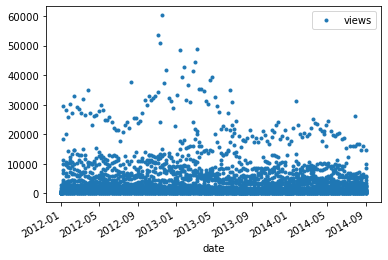

In [8]:
domestic_grouped.plot(style='.')

Here, we see that the weekly views are between 0 and 5000 for most of them, and then a few of them between 5000 and 15 000, and some outliers in 2014 that go up to 50 000. Again, this will need to be investigated later.

### Google Trends Data

We want to use Google Trends data in order to find spikes in the data corresponding to big news related to terrorism or domestic security happeneing between the timespan of our Wikipedia data. Our hypothesis is that Wikipedia views are impacted by the breaking news in the world. We could detect these events with Google Trends and remove the outlier data to provide another evidence - or not - of a chilling effect. 

We use the pytrends API to recover data from Google Trends. Because the Wikipedia topics are in english, we set the langage to english for requesting Google Trends as well.

In [9]:
# Setting to english
pytrends = TrendReq(hl='en-US', tz=360)

When defining the list of keywords we wanted to extract from Google Trends, we wanted to go for the same as the one from Wikipedia. However, we have to make manually some changes, because people don't write in the Google search bar the same way as an article title is written in Wikipedia. Thus, we first removed the '_' and '-' from the names of topics. We then checked manually that the key words made sense, and that's why we also had to remove the 'in the', otherwise some topics would not have any data.
We had a similar problem with 'tehrik i taliban pakistan' specifically, which had zero Google Trends data. But using their API, it suggested to replace it with 'tehrik-e-taliban' and we indeed had data for this one, so we replaced it.

So we create our list of topics.

In [10]:
# function used to clean the names of the articles
def clean_names(names):
  article_names_clean = names.str.replace('_', ' ')
  article_names_clean = article_names_clean.str.replace('-', ' ')
  article_names_clean = article_names_clean.str.replace('in the', ' ')
  article_names_clean = article_names_clean.str.replace('tehrik i taliban pakistan', 'tehrik-e-taliban')
  article_names_clean = article_names_clean.str.replace('\(anti terrorist unit\)', '')
  return article_names_clean

In [11]:
#function used to get all the google trends data from the topics gotten by cleaning the wiki articles names
def get_google_trends(names):
  # Cleaning topics names before querying them
  article_names_clean = clean_names(names)
  kw_list = article_names_clean.values
  print('List of topics :', kw_list)
  # First one, so that we get the index in a nice way right away
  pytrends.build_payload([kw_list[0]], cat=0, timeframe= '2012-01-01 2014-08-31', geo='', gprop='')
  one_article_views = pytrends.interest_over_time()
  df_google_trends = one_article_views[[kw_list[0]]]

  # Querying for all other keywords
  for key_word in kw_list[1:]:
    pytrends.build_payload([key_word], cat=0, timeframe= '2012-01-01 2014-08-31', geo='', gprop='')
    one_article_views = pytrends.interest_over_time()
    df_google_trends[key_word] = one_article_views[key_word]

  return df_google_trends

In [12]:
# How we first got the data : 
# df_google_trends = get_google_trends(terrorism_article_names)
# Use precomputed data

df_google_trends = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/google-trends-terror.csv")
df_google_trends.date = pd.to_datetime(df_google_trends.date)
df_google_trends = df_google_trends.set_index("date")
df_google_trends.head(5)

,abu sayyaf,al qaeda,al qaeda arabian peninsula,al qaeda islamic maghreb,al shabaab,biological weapon,car bomb,chemical weapon,conventional weapon,dirty bomb,...,palestine liberation front,political radicalism,recruitment,suicide attack,suicide bomber,taliban,tehrik-e-taliban,terror,terrorism,weapons grade
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,17,22,0,0,6,15,16,0,3,14,...,0,0,69,9,8,24,55,100,26,91
2012-01-08,8,24,0,0,7,0,20,2,0,9,...,0,0,70,9,14,100,0,98,32,29
2012-01-15,12,26,0,0,4,43,14,2,0,21,...,0,0,71,4,32,36,0,83,33,28
2012-01-22,24,23,0,0,7,71,15,1,0,17,...,0,0,66,6,14,35,0,78,34,0
2012-01-29,35,21,0,54,4,28,15,2,0,12,...,67,0,65,6,17,25,0,75,31,27


In [13]:
# How we first got the google trends : 
# df_google_trends_domestic = get_google_trends(domestic_article_names)
# Use precomputed data

df_google_trends_domestic = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/google-trends-domestic.csv")
df_google_trends_domestic.date = pd.to_datetime(df_google_trends_domestic.date)
df_google_trends_domestic = df_google_trends_domestic.set_index("date")
df_google_trends_domestic.head(5)

,air marshal,alcohol and tobacco tax and trade bureau,border patrol,bureau of land management,central intelligence agency,coast guard,customs and border protection,dea,emergency management,espionage,...,homeland defense,national guard,secret service,secure border initiative,task force 88,transportation security administration,u.s. immigration and customs enforcement,united nations,united states citizenship and immigration services,united states department of homeland security
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,32,0,34,27,46,65,43,80,23,38,...,63,69,9,0,0,73,33,52,27,0
2012-01-08,25,0,38,13,76,70,59,86,23,48,...,39,73,9,0,68,43,31,61,78,21
2012-01-15,36,0,31,15,75,89,65,82,28,36,...,29,65,9,0,0,34,0,59,25,20
2012-01-22,45,36,40,35,27,71,61,84,29,35,...,58,68,9,0,0,68,0,57,0,20
2012-01-29,35,0,38,27,31,62,90,81,24,38,...,38,64,10,0,0,75,30,57,0,20


Now that we have all our topics, we can query the API and create our dataframe from gathered data.

And now data from Google Trends is also ready !

### Statistics on the data

Let's have another quick look at the data we gathered, to understand it better before our analysis.


In [14]:
print("Number of articles (Wikipedia): ", len(terrorism_article_names))
print("Number of keywords (Google Trends): ", len(df_google_trends.columns))

Number of articles (Wikipedia):  30
Number of keywords (Google Trends):  30


In [15]:
print("Number of articles (Wikipedia): ", len(domestic_article_names))
print("Number of keywords (Google Trends): ", len(df_google_trends_domestic.columns))

Number of articles (Wikipedia):  25
Number of keywords (Google Trends):  25


In [16]:

def stats_wiki(df, grouped):
  ''' Statistics on Wikipedia articles : returns Daily mean, monthly mean, median and std'''

  print("== Statistics on Wikipedia articles ==")

  daily_mean_wiki = df.sum(axis=1).values.mean()
  print("\nAverage daily pageviews on Wikipedia:", daily_mean_wiki)

  monthly_mean_wiki = grouped.sum(axis=1).values.mean()
  print("\nAverage monthly pageviews on Wikipedia:", monthly_mean_wiki)

  monthly_median_wiki = np.median(grouped["views"].values)
  print("\nMedian of monthly pageviews on Wikipedia:", monthly_median_wiki)

  monthly_std_wiki = np.std(grouped["views"].values)
  print("\nStandard deviation of monthly pageviews on Wikipedia:", monthly_std_wiki)


In [17]:
def stats_trends(df):
  ''' Statistics on Google trends : returns Daily mean, monthly mean, median and std'''

  print("\n== Statistics on Google Trends ==")

  weekly_mean_trends = df.mean(axis=1).values.mean()
  print("\nAverage weekly queries percent on Google trends per article:", weekly_mean_trends, "%")

  weekly_median_trends = np.median(df.values)
  print("\nMedian of weekly queries percent on Google trends per article:", weekly_median_trends, "%")

  weekly_std_trends = np.std(df.values)
  print("\nStandard deviation of weekly queries percent on Google trends per article:", weekly_std_trends, "%")

In [18]:
#Stats on the terrorism datasets
stats_wiki(df_terrorism, terrorism_grouped)
stats_trends(df_google_trends)

== Statistics on Wikipedia articles ==

Average daily pageviews on Wikipedia: 876.4747433264887

Average monthly pageviews on Wikipedia: 6356.786904761905

Median of monthly pageviews on Wikipedia: 1734.5

Standard deviation of monthly pageviews on Wikipedia: 10610.657364226732

== Statistics on Google Trends ==

Average weekly queries percent on Google trends per article: 23.834761904761905 %

Median of weekly queries percent on Google trends per article: 20.0 %

Standard deviation of weekly queries percent on Google trends per article: 21.86754131214913 %


In [19]:
#Stats on the domestic security datasets
stats_wiki(df_domestic, domestic_grouped)
stats_trends(df_google_trends_domestic)

== Statistics on Wikipedia articles ==

Average daily pageviews on Wikipedia: 1069.245749486653

Average monthly pageviews on Wikipedia: 4008.3860248447204

Median of monthly pageviews on Wikipedia: 1832.0

Standard deviation of monthly pageviews on Wikipedia: 6106.23101407555

== Statistics on Google Trends ==

Average weekly queries percent on Google trends per article: 34.005714285714284 %

Median of weekly queries percent on Google trends per article: 32.0 %

Standard deviation of weekly queries percent on Google trends per article: 24.950727935068265 %


From these statistics, we can already see that the Wikipedia articles have a quite inequal number of views. This is illustrated by the median and the mean being very different, meaning that there are some extreme values that push the mean upwards. Recall the first plot of the data, we indeed observed these outliers. Also, the standard deviation is very high for both datasets, that also goes into the direction of some articles having an important weight in the total number of views.

We see that this is less the case in Google Trends data, because data is normalized. However we still have a quite large standard deviation of 22% and 25%. This is probably due to the fact that the data **has** to range from 0 to 100, and some spikes in the data causes the standard deviation to be higher.

## Which topics are the most important for the trends ?
We begin to identify which article has the most Wikipedia traffic overall. These will be the articles that we saw in the first plots as outliers, but didn't know which one there were. Let us look at the five highest ones.

### Top Five

In [20]:
def top_five_topics(df):
  ''' Finds the 5 topics in the dataframe that have the highest total view count'''
  
  total_views_articles = df.groupby("article").sum().sort_values("views")
  total_views = float(total_views_articles.sum())
  precentage_views_articles = total_views_articles.apply(lambda x : x/total_views)
  # Let's see the five highest ones
  print('Percentage weight of top 5 topics with the most traffic : ', precentage_views_articles.tail(5).sum()['views'])
  print(precentage_views_articles.tail(5))

In [21]:
print('==== Top Five Topics for Study Group in Terrorism dataset ====')
top_five_topics(terrorism_grouped)

==== Top Five Topics for Study Group in Terrorism dataset ====
Percentage weight of top 5 topics with the most traffic :  0.6503365263335906
              views
article            
jihad      0.089476
hezbollah  0.097927
terrorism  0.108594
taliban    0.153866
al-qaeda   0.200473


Al-qaeda alone counts for 20% of the views ! And two third of the total views are made by the top five articles ! That means that a change in one or more of them, maybe unrelated with Snowden's revelations, would impact the whole trend.

In [22]:
print('==== Top Five Topics for Study Group in Domestic Security dataset ====')
top_five_topics(domestic_grouped)

==== Top Five Topics for Study Group in Domestic Security dataset ====
Percentage weight of top 5 topics with the most traffic :  0.6550787971460145
                                                  views
article                                                
federal_emergency_management_agency            0.066473
emergency_management                           0.083945
united_states_department_of_homeland_security  0.095138
espionage                                      0.132093
central_intelligence_agency                    0.277429


Here, we have the CIA that is accounting for a lot of views and that might impact the trends quite a lot, the others are more thant 14% less and quite well distributed.


Now we are making a visualisation of this result a little nicer, with a World Cloud, for our Data Story.

### World Cloud

We want to make a visualization of the relative importance of different topics in the whole dataset by making a word cloud.

In [23]:
def visualize_world_cloud(df):
  ''' World Cloud Visualisation from DataFrame'''
  df_sum_t = df.groupby("article").sum()
  df_sum_t['views'] = np.log(df_sum_t['views'])
  df_sum_t = df_sum_t['views'].apply(lambda x: float(x))
  wordcloud = WordCloud(relative_scaling=1,normalize_plurals=False, background_color="white", width=800, height=400).generate_from_frequencies(df_sum_t)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

  return df_sum_t, wordcloud

Let's visualize the terrorism-related importance of topics.

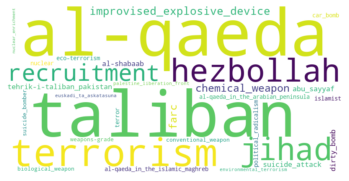

In [24]:
df_sum_t, wordcloud_t= visualize_world_cloud(terrorism_grouped)
wordcloud_t.to_file("pwc_t.png")

This shows the same thing as before, that five topics (al-qaeda, taliban,...) really stand out from others and have a huge weight in the total trends.

Let's do the same with the domestic security related articles.

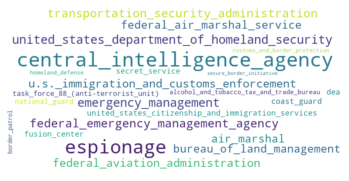

In [25]:
df_sum_d, world_cloud_d = visualize_world_cloud(domestic_grouped)
world_cloud_d.to_file("pwc_d.png")

Again, this goes into the direction of our first findings, that the CIA is the topic with the most importance, but the rest of the keywords are quite well balanced.

## Analyse Google Trends for the paper keywords

### Identify what makes an outlier

We will now try to identify, using our Google Trends data, outliers.
We define an outlier as a being a point that is abnormally higher than the previous one . How to define that ? We will analyse the derivate of the Google Trends data and retain points that are far from the mean value. But what does 'far' means ? We will define a threshold based on the outlier that they defined in the paper : Hamas. Every data point that has a higher derivative than the threshold for the topic will be taken care of, we will see later how. 

We first need to load data for Hamas, because it was not in their final dataset. 

In [26]:
# Read those from pickle for reproducibility!
# But this is how we did it for the first time
#pytrends.build_payload(['Hamas'], cat=0, timeframe= '2012-01-01 2014-08-31', geo='', gprop='')
#hamas_gt = pytrends.interest_over_time().drop(['isPartial'], axis=1)
#hamas_gt.to_pickle("Hamas.pickle")

hamas_gt = pd.read_pickle("https://mbien-public.s3.eu-central-1.amazonaws.com/cs-401/Hamas.pickle")

We plot the derivative of Hamas Google Trends values.

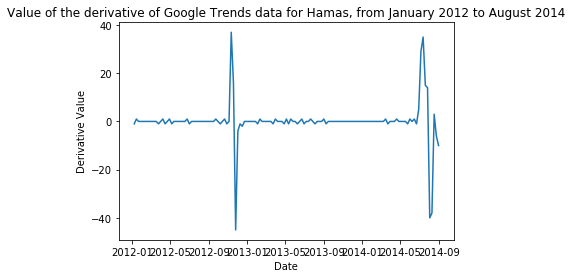

In [27]:
#getting the derivative of the Hamas data and plotting it
hamas_der = hamas_gt.diff()['Hamas']
mean_der = hamas_der.mean()
std_der = hamas_der.std()
plt.xlabel('Date')
plt.ylabel('Derivative Value')
plt.title('Value of the derivative of Google Trends data for Hamas, from January 2012 to August 2014')
plt.plot(hamas_der)

We see that there are two sharp spikes. In the paper, they put out Hamas from their dataset because of them. 

" *The operation officially began on November 14, 2012, and ended on November 21, 2012 with an Egypt-brokered ceasefire. Then, in July 2014, Israel launched “Operation Protective Edge,” which is an IDF operation in Gaza against Hamas. [...] These two high profile conflicts coincide with a dramatic and
anomalous increase in the view counts during those months for the
Wikipedia article on “Hamas” in the dataset. [...] A second set of results from the analysis, which excludes the outlier data concerning the Hamas article, is presented here [...]* "

Let's find the threshold of the number of standard deviations away from the mean of derivatives the outlier is. 

Date of the Outliers : 
date
2012-11-11    37.0
2014-07-13    35.0
Name: Hamas, dtype: float64
Number of standard deviations difference between outlier and mean :  4.233161317793279


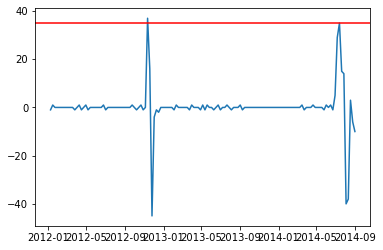

In [28]:
# Values of the two spikes
top_values = hamas_der.nlargest(2)
print('Date of the Outliers : ')
print(top_values)
min_top_values = top_values.min()

# Computing the number of std away from the mean they are
n_std = (min_top_values - mean_der)/std_der
print('Number of standard deviations difference between outlier and mean : ', n_std)
threshold = mean_der + n_std*std_der
plt.plot(hamas_der)
plt.axhline(y=threshold, color='r', linestyle='-')

As Hamas is the only outlier that the paper picks, we decided then to use this n_std to compute the threshold to search for other possible outliers in our datasets.

### Visualize outliers

We will now state that every other peak in derivatives in each topic that is more than n_std is considered also as an outlier, and we will need to investigate the cause of the peak, and remove it from the study.

Let's look have a quick look at all the terrorism topics.

In [29]:
def find_threshold(topic_data, n_std):
  ''' Calculates the threshold from which a point is considered as an outlier, using the n_std calculated from Hamas outliers '''
  derivative = topic_data.diff()
  mean_der = derivative.mean()
  std_der = derivative.std()
  threshold = mean_der + n_std*std_der
  return derivative, threshold

In [30]:
def visualize_thresholds(topics_google, df, plot_columns):
  ''' Ploting all the study group topics and their associated threshold '''
  fig, axes = plt.subplots(round(len(topics_google)/plot_columns), plot_columns, figsize=(25,25), sharex=True, sharey=False)
  
  for num, topic in enumerate(topics_google):
    derivative, threshold = find_threshold(df[topic], n_std)
    ax = axes[int(num/plot_columns), num%plot_columns]
    ax.plot(derivative)
    ax.axhline(y=threshold, color='r', linestyle='-')
    ax.set_title(topics_google[num])
    ax.yaxis.set_ticklabels([])

    if num%plot_columns==0:
      ax.set_ylabel("Google Trend Meter")


Let's see the topics' Google trends and visualize the threshold along them.

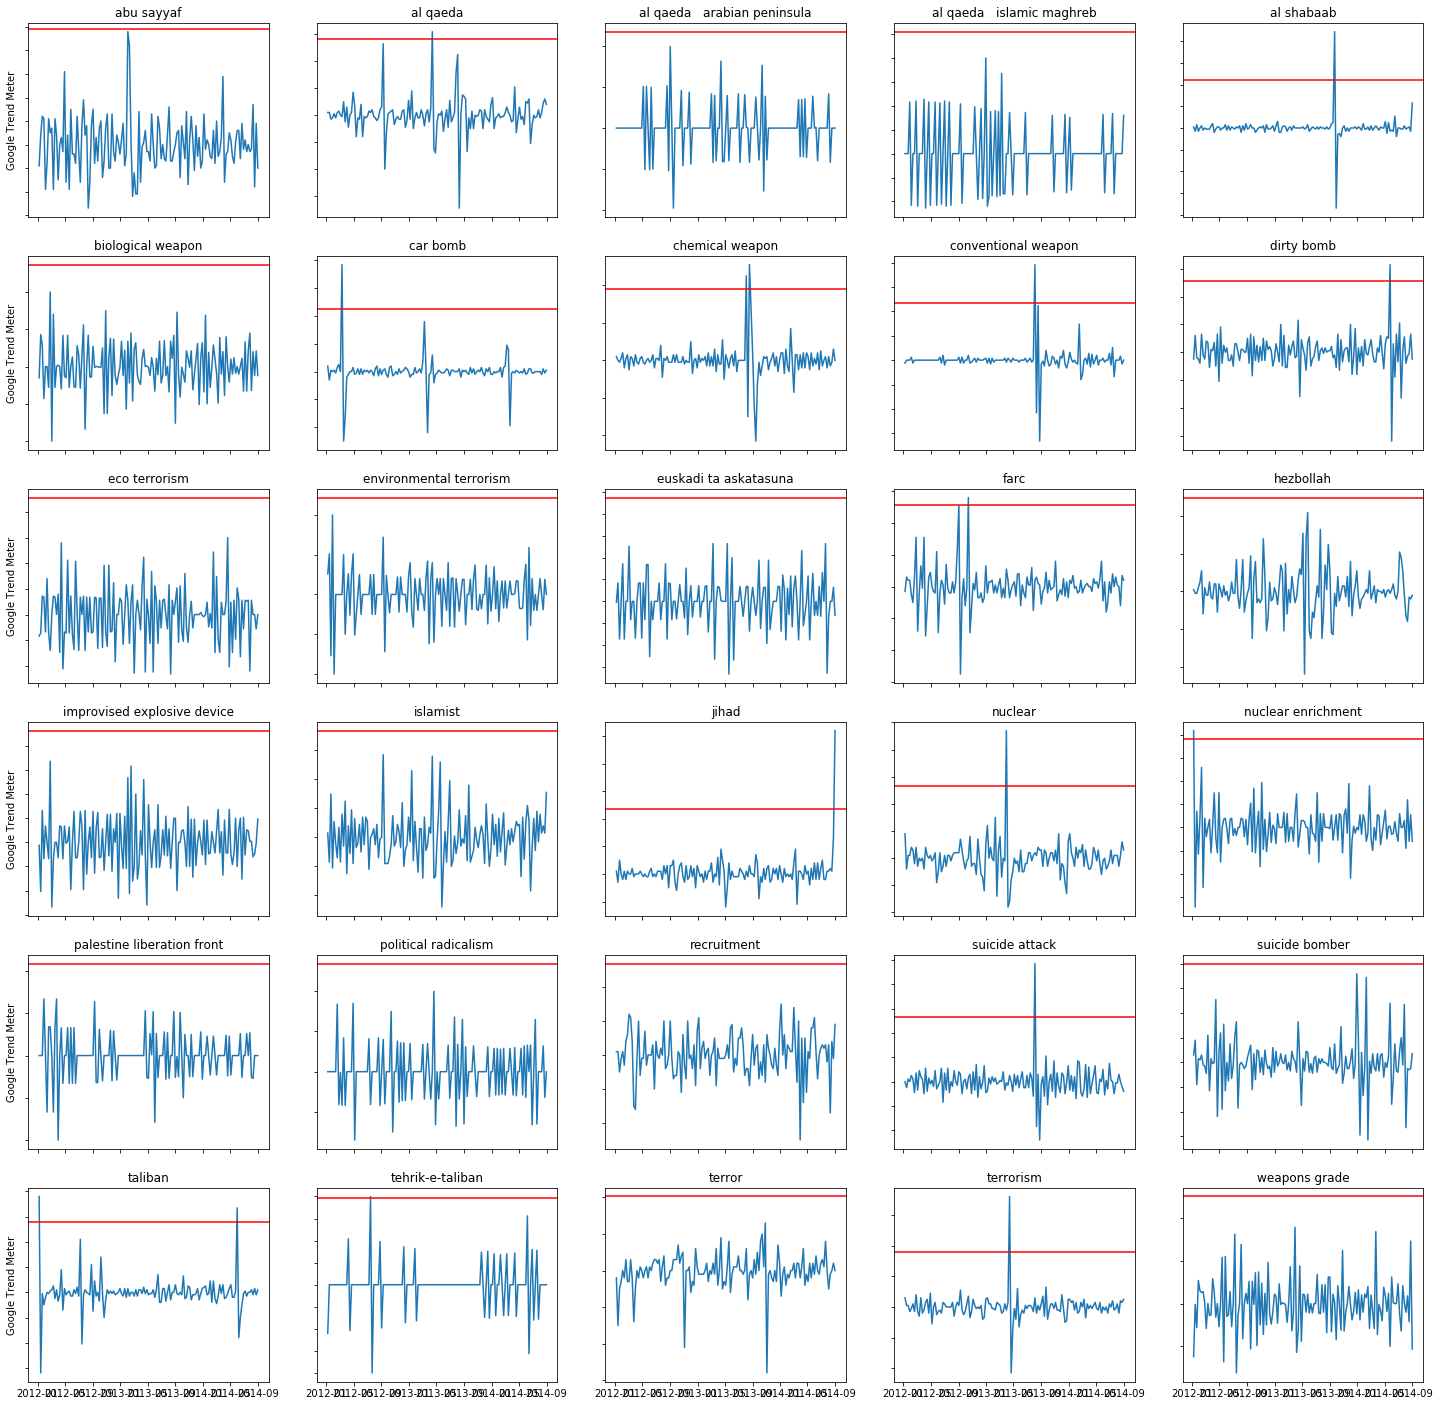

In [31]:
visualize_thresholds(clean_names(terrorism_article_names), df_google_trends, 5)

We see that we managed to find a way to identify other outliers, the ones more or as extreme as the one from the paper.

### Extracting all the outliers

Now, we extract the list of outliers so that we know which days and topics we need to treat later.

In [32]:
def find_outliers(df, names):
  ''' Finding all the outliers from the Google Trends dataframe'''
  # Go through all of the topics and replace outliers with the mean of the month
  df_google_trends_no = df.copy()

  outliers = []

  #go through all the topics
  for num, topic in enumerate(clean_names(names)):
    topic_data = df[topic]
    #get derivative and threshold
    derivative, threshold = find_threshold(df[topic], n_std)

  #for all derivatives values, if it is bigger that the threshold, the data entry is considered an outlier
    for i, val in enumerate(derivative.values):
      if val >= threshold:
        outliers.append([topic, topic_data.index[i]])

  #create dataframe with the outliers
  outliers = pd.DataFrame(outliers, columns=["topic","date"])
  print("The outliers are:\n {}".format(outliers))
  return outliers

Outliers of 'terrorism' dataset :

In [33]:
outliers = find_outliers(df_google_trends, terrorism_article_names)

The outliers are:
                   topic       date
0              al qaeda 2013-04-14
1            al shabaab 2013-09-22
2              car bomb 2012-03-11
3       chemical weapon 2013-08-04
4       chemical weapon 2013-08-18
5   conventional weapon 2013-08-04
6            dirty bomb 2014-05-25
7                  farc 2012-10-14
8                 jihad 2014-08-31
9               nuclear 2013-03-31
10   nuclear enrichment 2012-01-08
11       suicide attack 2013-08-04
12              taliban 2012-01-08
13              taliban 2014-06-01
14     tehrik-e-taliban 2012-07-15
15            terrorism 2013-04-14


We have 16 outliers ! Half of them are before Snowden's revelations, the other half after.

Now the outliers of 'domestic' dataset :

In [34]:
outliers_domestic = find_outliers(df_google_trends_domestic, domestic_article_names)

The outliers are:
                          topic       date
0                  air marshal 2014-05-25
1                border patrol 2012-09-30
2    bureau of land management 2014-04-06
3                  coast guard 2012-02-26
4         emergency management 2012-10-28
5  federal air marshal service 2014-04-06
6               national guard 2014-08-17
7               secret service 2012-04-15


Here we have 8 of them, again half of them occured before the revelations.

### Linking all the outliers with the related events

Now, we want to explore the cause of this outliers. What caused a such important and extraordinary amount of queries these days ? To do that, we searched for each day and topic on the web, and summarized all in a new column of our dataframe. The '?' data is where we couldn't find anything related to that day and topic. These '?' happened only on topics that are not really popular and thus have a higher standard deviation in Google trends data, having a lot of zeros and then 100 and then going back to 0. It won't affect our results very much because they don't have a lot of views anyway, so not a lot of impact in the global trend.

In [35]:
# Adding the event corresponding to the outliers 

outliers["event"] = ["Bombings at Boston marathon",
                               "Shooting claimed by Al-Shabaab in a shopping mall in Kenya, 71 deaths",
                               "Irish Car Bomb is a traditional cocktail done on St-Patrick’s day",
                               "Talk of Syria using chemical weapons",
                               "Two alleged chemical weapons attacks in Syria on the 21",
                               "Arms Trade Treaty",
                               "?",
                               "Peace talks with FARC announced",
                               "Talks of Love Jihad", 
                               "North Korea threatens nuclear attacks against US and South Korea",
                               "Negotiations over Iran's nuclear programme",
                               "Suicide bombing in Quetta, Pakistan",
                               "?",
                               "Taliban attack on Karachi airport",
                               "Footage of Marines urinating on Taliban corpses",
                               "Bombings at Boston marathon"]

# We also have data for the domestic dataset, but we won't use it for our datastory nor analysis
# We still looked for them so here there are
#outliers_domestic["event"] = ["Border patrol agent killed in Arizona",\
#                               "'Range war' in Nevada",\
#                               "Hurricane Sandy",\
#                               "US secret agent prostitution scandal",\
#                               "No event found",\
#                               "No event found",\
#                               "Obama speech at UN"]
outliers.head()

,topic,date,event
0,al qaeda,2013-04-14,Bombings at Boston marathon
1,al shabaab,2013-09-22,Shooting claimed by Al-Shabaab in a shopping m...
2,car bomb,2012-03-11,Irish Car Bomb is a traditional cocktail done ...
3,chemical weapon,2013-08-04,Talk of Syria using chemical weapons
4,chemical weapon,2013-08-18,Two alleged chemical weapons attacks in Syria ...


### Visualizing all the external events

To visualize them in a nice way, we choose to display a timeline and a line for each topic. If the case is red, then it means an external event occured on this month and we can hover on it to get the description. This will be put in our data story.

In [36]:
# Finding year and week for the outliers
outliers["week"] = outliers.date.apply(lambda date: date.weekofyear*7)
outliers["year"] = outliers.date.apply(lambda date: date.year)
outliers.head()

,topic,date,event,week,year
0,al qaeda,2013-04-14,Bombings at Boston marathon,105,2013
1,al shabaab,2013-09-22,Shooting claimed by Al-Shabaab in a shopping m...,266,2013
2,car bomb,2012-03-11,Irish Car Bomb is a traditional cocktail done ...,70,2012
3,chemical weapon,2013-08-04,Talk of Syria using chemical weapons,217,2013
4,chemical weapon,2013-08-18,Two alleged chemical weapons attacks in Syria ...,231,2013


In [37]:
# Creating the plotly figure
z_val = []
z_text = []

for topic in outliers.topic.unique():
  z_val_sub = []
  z_text_sub = []
  for date in sorted(outliers.date.unique()):
    row = outliers[(outliers.date==date) & (outliers.topic==topic)]
    if len(row)==0:
      z_val_sub.append(None)
      z_text_sub.append("")
    else:
      z_val_sub.append(1)
      z_text_sub.append(row.event.values[0])
  z_val.append(z_val_sub)
  z_text.append(z_text_sub)


In [38]:
pd.to_datetime(sorted(outliers.date.unique())).strftime("%d %B %Y").values

array(['08 January 2012', '11 March 2012', '15 July 2012',
       '14 October 2012', '31 March 2013', '14 April 2013',
       '04 August 2013', '18 August 2013', '22 September 2013',
       '25 May 2014', '01 June 2014', '31 August 2014'], dtype=object)

In [ ]:
fig_main = go.Figure(data=go.Heatmap(
    x=pd.to_datetime(sorted(outliers.date.unique())).strftime("%d %B %Y").values,
    y=outliers.topic.unique(),
    z=z_val,
    text=z_text,
    type="heatmap",
    hoverongaps = False,
    hovertemplate='Cause: %{text}<br><br>Date: %{x}<br>Topic: %{y}<extra></extra>'
))

fig_main.update_traces(showscale=False)
fig_main.update_layout(title='Timeline For Outliers in Every Topic')
fig_main.show()
fig_main.write_html("fig_main.html", include_plotlyjs=False, full_html=False)

### Example of Chemical Weapon

Let's look at one arbitrarily topic that got an outlier, and find the breaking news associated. We choose 'Chemical weapon' here. Let's look at what happened on the week of August 18th in 2013. A few google searches and we find that there was an attack with the Ghouta chemical attack, during the Syrian civil war. Here is the longer Wikipedia article :  https://en.wikipedia.org/wiki/Ghouta_chemical_attack

In [40]:
cw = df_google_trends['chemical weapon']

In [ ]:
#visualize the spike in views with the event associated
fig_cw = px.line(cw, x=cw.index, y=cw.values, labels={'x': 'Week', 'y': 'Views'}, width=600, range_y=(0, 110))
fig_cw.add_trace(go.Scatter(
    x=[pd.to_datetime("08-21-2013"), pd.to_datetime("08-21-2013")],
    y=[0,100],
    mode="lines+text",
    name="Lines, Markers and Text",
    text=["", "Ghouta attack"],
    textposition="top center", showlegend=False
))
fig_cw.update_layout(title='Spike Detected By Google Trends On Wikipedia Data')
fig_cw.show()
fig_cw.write_html("fig_chemical.html", include_plotlyjs=False, full_html=False)


### Example of Car Bomb

Let's look at another interesting finding of ours. There are those recurrent spikes for the 'car bomb' keyword. Every year. On St Patrick's Day. After some research, we found out that it was because the Irish Car Bomb is actually an irish traditional cocktail :)

It makes even more sense to remove these outliers days from our data.

In [ ]:
# Plotly for 'car bomb'
cb = df_google_trends['car bomb']

fig_cb = px.line(cb, x=cb.index, y=cb.values, labels={'x': 'Week', 'y': 'Views'}, width=600, range_y=(0, 110))
fig_cb.add_trace(go.Scatter(
    x=[pd.to_datetime("03-17-2012"), pd.to_datetime("03-17-2012")],
    y=[0,100],
    mode="lines+text",
    name="Lines, Markers and Text",
    text=["", "St Patrick's"],
    textposition="top center", showlegend=False
))

fig_cb.add_trace(go.Scatter(
    x=[pd.to_datetime("03-17-2013"), pd.to_datetime("03-17-2013")],
    y=[0,100],
    mode="lines+text",
    name="Lines, Markers and Text",
    text=["", "St Patrick's"],
    textposition="top center", showlegend=False
))

fig_cb.add_trace(go.Scatter(
    x=[pd.to_datetime("03-17-2014"), pd.to_datetime("03-17-2014")],
    y=[0,100],
    mode="lines+text",
    name="Lines, Markers and Text",
    text=["", "St Patrick's"],
    textposition="top center", showlegend=False
))
fig_cb.update_layout(title='Spikes In Wikipedia For Car Bomb')
fig_cb.show()
fig_cb.write_html("fig_patrick.html", include_plotlyjs=False, full_html=False)

## Wikipedia without outliers

Now that we know when and on which topics there are outliers, we want to realign it in the Wikipedia data. Our approach is to replace the data from the month of the outlier - because as we can see on the previous plots for example, the spikes are not only on a specific week, but also continuing for a month. We assume that this will be the case for the other events generally. We replace data for this month with the mean of the number of views from the previous month.

### From the paper

We first reproduce quickly the results from the paper, to use them in our data story.

In [ ]:
#Plotting the trend of Wikipedia views before June 2013
terrorism_means = terrorism_grouped.groupby("date").mean()
terrorism_pre = terrorism_means[terrorism_means.index<"06-10-2013"].reset_index()
terrorism_after = terrorism_means[terrorism_means.index>="06-10-2013"].reset_index()

fig1 = px.scatter(terrorism_pre, x="date", y="views", trendline="ols", width=600)
fig1.update_layout(title='Wikipedia View Trends Before June 2013')
fig1.write_html("fig1.html", include_plotlyjs=False, full_html=False)
fig1.show()

In [ ]:
#Plotting the trend of Wikipedia views after June 2013
fig2 = px.scatter(terrorism_after, x="date", y="views", trendline="ols", width=600)
fig2.update_layout(title='Wikipedia View Trends After June 2013')
fig2.write_html("fig2.html", include_plotlyjs=False, full_html=False)
fig2.show()

### Removing The Outliers In Wikipedia

Now it is time to remove these outliers ! We create a new dataframe with the outliers values replaced by the mean from the previous month.

In [45]:
MONTH_SIZE = 5

def remove_outliers(data_grouped, outliers):
  data_grouped.article = data_grouped.article.str.replace("_|-", " ", regex=True)


  #for all outliers found from the google trends find the corresponding value (if existing) in the terrorism wiki data
  #and replace it with the mean of the month before
  for i in outliers.index:
    if len(data_grouped[(data_grouped.article.values == outliers.topic[i]) & (data_grouped.index == outliers.date[i])].views.values)>0:
      date_range = pd.date_range(outliers.date[i]+relativedelta(months=-1), outliers.date[i])
      matched_article = data_grouped[data_grouped.article.values == outliers.topic[i]]
      mean_views = matched_article[matched_article.index.isin(date_range)].views.mean()

      for w in range(MONTH_SIZE):
        data_grouped.loc[(data_grouped.article.values == outliers.topic[i]) & (data_grouped.index == outliers.date[i]+relativedelta(weeks=w)), "views"] = mean_views 
  return data_grouped

In [46]:
# Removing outliers for terrorism dataset
terrorism_grouped_no = terrorism_grouped.copy()
terrorism_grouped_no = remove_outliers(terrorism_grouped_no, outliers)

# Removing outliers for domestic dataset
domestic_grouped_no = domestic_grouped.copy()
domestic_grouped_no = remove_outliers(domestic_grouped_no, outliers_domestic)

Let's see if it worked on the 'terrorism' outlier of the 2013-04-14, and compare the data before and after the realigning of the data.

In [47]:
terrorism_grouped_no[terrorism_grouped_no.article=='terrorism'][65:75]

,article,views
date,,
2013-03-31,terrorism,21652.0
2013-04-07,terrorism,21001.0
2013-04-14,terrorism,24584.2
2013-04-21,terrorism,24584.2
2013-04-28,terrorism,24584.2
2013-05-05,terrorism,24584.2
2013-05-12,terrorism,24584.2
2013-05-19,terrorism,33197.0
2013-05-26,terrorism,47282.0


The data has been successfully re-aligned !
Let's visually see it.

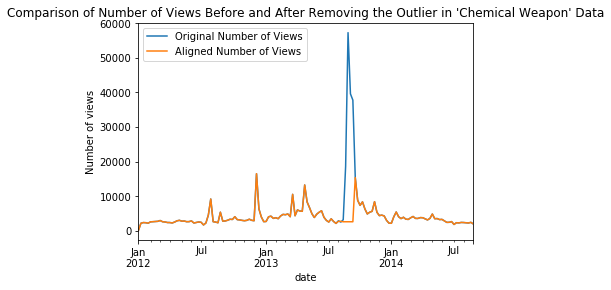

In [48]:
ax = terrorism_grouped[terrorism_grouped.article=="chemical_weapon"].rename(columns={'views':'Original Number of Views'}).plot(title="Comparison of Number of Views Before and After Removing the Outlier in 'Chemical Weapon' Data", xlabel='Date', ylabel = 'Number of views')
terrorism_grouped_no[terrorism_grouped_no.article=="chemical weapon"].rename(columns={'views':'Aligned Number of Views'}).plot(ax=ax)

And the plotly for our data story for this previous plot.

In [ ]:
#plot the change in views after removing outlier in chemical weapon for data story plotly
chemical_before = terrorism_grouped[terrorism_grouped.article=="chemical_weapon"]
chemical_after = terrorism_grouped_no[terrorism_grouped_no.article=="chemical weapon"]

fig_outlier = go.Figure()
fig_outlier.update_layout(width=600, showlegend=True, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.05),
    xaxis_title='Week',
    yaxis_title='Number of views'
)
fig_outlier.add_trace(go.Scatter(
    x=chemical_before.index,
    y=chemical_before.views,
    mode="lines",
    name="Original number of views"))

fig_outlier.add_trace(go.Scatter(
    x=chemical_after.index,
    y=chemical_after.views,
    mode="lines",
    name="Aligned number of views"))

fig_outlier.update_layout(title='Wikipedia Data With and Without Outliers')
fig_outlier.show()

fig_outlier.write_html("figalignment.html", include_plotlyjs=False, full_html=False)

We see that we successfully managed to take care of the outlier, and the data now looks as if no extraordinary event happened.

### Segmented Regression Analysis on Wikipedia data without outliers

Now that we have our treated data, we can reproduce the analysis the authors did in their paper, but without the outliers. Let's see if we have the same results.

In [50]:
def segmented_regression(df):
  ''' Create new dataframe for the regression and add necessary variables:
   time is number of days from first data point
   intervention is equal to 0 before the event of June 2013 and 1 after
   postslope is number of days after event '''

  df = df.groupby(pd.Grouper(freq='M'))[["views"]].sum()
  df_plot = df.copy()
  df["time"] = range(1, len(df)+1)

  df["intervention"] = 0
  after_event = pd.date_range("2013-06", "2014-09")
  mask_after = df.index.isin(after_event)
  df[mask_after] = df[mask_after].replace([0], 1)

  postslope = np.concatenate((np.zeros(len(df) - len(df[mask_after])), np.array(range(1, len(df[mask_after])+1))))
  df["postslope"] = postslope 

  #model for linear regression
  model = smf.ols(formula='views ~ time+ C(intervention) + postslope', data=df)

  # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
  np.random.seed(2)
  result = model.fit()

  print(result.summary())

  #calculate regression line
  regression = result.predict(df)

  return df, regression, mask_after


In [51]:
#regression for terrorism data
terrorism_no_df, regression, mask_after = segmented_regression(terrorism_grouped_no)

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     13.53
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.22e-05
Time:                        18:22:07   Log-Likelihood:                -421.07
No. Observations:                  32   AIC:                             850.1
Df Residuals:                      28   BIC:                             856.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               5.5e+05 

In [52]:
#regression for domestic security data
domestic_no_df, regression_domestic, mask_after_domestic = segmented_regression(domestic_grouped_no)

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     7.385
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           0.000856
Time:                        18:22:08   Log-Likelihood:                -399.57
No. Observations:                  32   AIC:                             807.1
Df Residuals:                      28   BIC:                             813.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              3.98e+05 

Now that we have our regression results, let's plot and visualize them.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



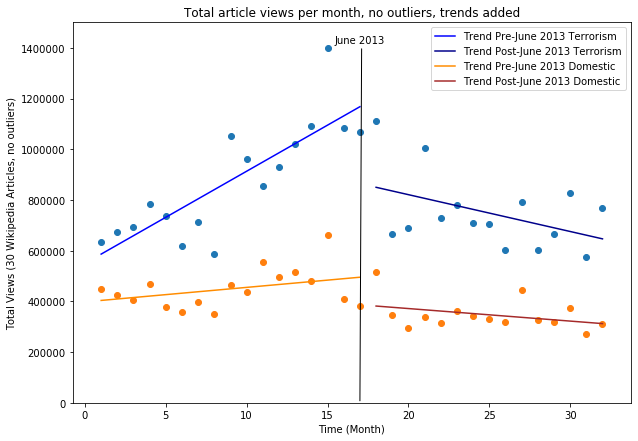

In [53]:
#visualize data without outliers of views per month with mark at June 2013
plt.figure(figsize=(10,7))
ax = plt.scatter(terrorism_no_df["time"], terrorism_no_df["views"])
plt.scatter(domestic_no_df["time"], domestic_no_df["views"])
plt.title("Total article views per month, no outliers, trends added")
plt.ylim(0, max(terrorism_no_df["views"])+100000)
plt.annotate('June 2013 ', xy=(17, 0), xytext=(-25, 360), xycoords = 'data', textcoords="offset points", arrowprops=dict(arrowstyle='-'))

plt.xlabel ('Time (Month)')
plt.ylabel ('Total Views (30 Wikipedia Articles, no outliers)')



#add the regression line before and after the event of June 2013
plt.plot(terrorism_no_df["time"][~mask_after],regression[~mask_after],'k-', color = 'blue', label="Trend Pre-June 2013 Terrorism")
plt.plot(terrorism_no_df["time"][mask_after],regression[mask_after],'k-', color = 'darkblue', label="Trend Post-June 2013 Terrorism")
plt.plot(domestic_no_df["time"][~mask_after_domestic],regression_domestic[~mask_after_domestic],'k-', color = 'darkorange', label="Trend Pre-June 2013 Domestic")
plt.plot(domestic_no_df["time"][mask_after_domestic],regression_domestic[mask_after_domestic],'k-', color = 'brown', label="Trend Post-June 2013 Domestic")

plt.legend(loc='best')

Interesting, the trends look qualitatively very much the same as they did in the paper.

### Plotly Segmented Regression

Again, here is the plotly for our datastory, basically the same figure as before, but without the domestic data and interactive.

In [ ]:
fig_final = px.scatter(terrorism_no_df, x="time", y="views", labels={'time': 'Month', 'views': 'Monthly Views withot outliers (30 Terrorism articles)'}, width=600, range_y=(0, 1500000))

fig_final.add_trace(go.Scatter(
    x=[17, 17],
    y=[0, 1500000],
    mode="lines",
    name="Snowden news",
    textposition="top center"
))

fig_final.add_trace(go.Scatter(
    x=terrorism_no_df["time"][~mask_after][:-1],
    y=regression[~mask_after][:-1],
    mode="lines",
    name="Trend pre-june 2013"
))


fig_final.add_trace(go.Scatter(
    x=terrorism_no_df["time"][mask_after],
    y=regression[mask_after],
    mode="lines",
    name="Trend post-june 2013"
))

fig_final.update_layout(legend=dict(
    yanchor="top",
    y=1.0,
    xanchor="left",
    x=0.6
))

fig_final.update_layout(title='Total article views per month, no outliers, trends added')
fig_final.show()
fig_final.write_html("fig_final.html", include_plotlyjs=False, full_html=False)

## Analysis of Results and Conclusion

Let's analyse our results taking our research questions. 

## Research questions

* How big is the importance of each separate article trend on the original paper results?
* How important was the influence of the external events on the weekly wikipedia views?
* Is the original paper's result still relevant if we reduce the impact of "breaking news" and topic popularity disproportion in the original data, as such can the results be reproduced using a more general data set, such as Google Trends?

First, one of our first questions was to analyse the weight of each paper in the overall trend. We saw that for the terrorism dataset, a few words had a quite important wieght in that. Moreover, we found out later that these words, such as 'terrorsim', had some outliers weeks. Outlier weeks are weeks where a breaking news unrelated to Snowden's revelations happened, that disrupt the global trend. We could retrieve for most of the outliers an event related to the day and topic.

Then, we can see that there is still an immediate and statistically significant decrease in view counts following the June 2013 revelations. In the paper, they had an immediate drop of 693 617 total views. Here we have a less sudden drop of 296 882. It still suggests that the revelations are associated with a sharp decrease, which is consistent with the hypothesis of a chilling effect.

In the paper, they stated that the effect was lasting in time. That the decreasing trend was lasting after June 2013, and that before it was only increasing. Here, we have for the terrorism data that the trend also completely changed after the revelations. It started with an increase of 36 330 (41 421 in the original paper) views per month, and after the intervention it is a decrease of 14 520 (26 092 in the paper) monthly views. We still have the same results than the authour, a bit less striking, but the effect is still there and our results for the terrorism data are all statistically significant (p-value < 0.05). We are aligned with the results of the paper, which were going into the direction of a long term chilling effect.

We also compare our results from the study group to the ones from our comparator group. What we suppose, as they did in the paper, is that "*if the “treatment group” is impacted while the control group is not, the inference that the treatment or intervention caused any observed impact is strengthened*."

We can begin by comparing their immediate drop-off, as the author of the study did. We have an drop-off of 14%, while we had one of 24% in the study group, and the trends changes are statistically significant in both cases (p-value < 0.05). That is a different result from the study, in which they had only statistically significant changes for the study group.  

About the long term effect on the comparator group, the results were not statistically significant (p-value of 0.103 and 0.055), but it was not as striking as in the paper (p-value of 0.531 and 0.551). Still, we cannot say that this model for domestic data fits the view count, implying no chilling effect on this side.

In conclusion, our results are going into the same direction as the ones in the paper, even if it is less striking. Data is being consistent with a chilling effect hypothesis where terrorism-related articles are impacted whether security-related articles are not, as they are not raising any privacy concerns.